In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
df=pd.read_csv('/content/GE.csv')

In [4]:
df.shape

(15471, 7)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15471 entries, 0 to 15470
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15471 non-null  object 
 1   Open       15471 non-null  float64
 2   High       15471 non-null  float64
 3   Low        15471 non-null  float64
 4   Close      15471 non-null  float64
 5   Adj Close  15471 non-null  float64
 6   Volume     15471 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 846.2+ KB


In [12]:
train_dates=pd.to_datetime(df.Date)

In [ ]:
train_dates

In [14]:
cols=list(df)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [16]:
df_for_training=df[cols].astype(float)
df_for_training

,Open,High,Low,Close,Adj Close
0,4.691347,4.769536,4.644433,4.675709,0.785728
1,4.652252,4.652252,4.613158,4.628796,0.777844
2,4.628796,4.667890,4.534969,4.574063,0.768647
3,4.574063,4.581882,4.378590,4.456780,0.748938
4,4.456780,4.456780,4.316039,4.448961,0.747623
...,...,...,...,...,...
15466,106.309998,106.889999,105.650002,106.230003,106.230003
15467,106.029999,107.150002,105.809998,106.739998,106.739998
15468,106.720001,106.800003,103.959999,104.699997,104.699997
15469,104.440002,105.639999,103.989998,105.410004,105.410004


<Axes: >

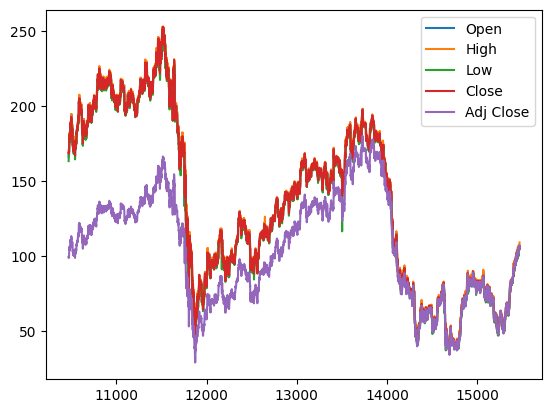

In [17]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [18]:
scaler=StandardScaler()
df_for_training_scaled=scaler.fit_transform(df_for_training)

In [19]:
df_for_training_scaled

array([[-0.87495453, -0.87435645, -0.8750696 , -0.87499109, -0.89264392],
       [-0.87543517, -0.87578275, -0.87545855, -0.87556781, -0.89278639],
       [-0.87572354, -0.87559258, -0.87643094, -0.87624067, -0.89295258],
       ...,
       [ 0.37939317,  0.36644225,  0.36006152,  0.35465149,  0.98516508],
       [ 0.3513627 ,  0.35233537,  0.3604346 ,  0.36337992,  0.99799544],
       [ 0.36992669,  0.39198047,  0.38468569,  0.37419811,  1.01389765]])

In [21]:
trainX=[]
trainY=[]

n_future=1
n_past=14

for i in range(n_past,len(df_for_training_scaled)-n_future+1):
  trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
  trainY.append(df_for_training_scaled[i+n_future - 1:i+n_future,0])

In [27]:
type(trainX)

numpy.ndarray

In [26]:
trainX,trainY =np.array(trainX),np.array(trainY)

In [29]:
print(f'trainX shape == {trainX.shape}.')
print(f'trainY shape == {trainY.shape}.')

trainX shape == (15457, 14, 5).
trainY shape == (15457, 1).


In [30]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/5
870/870 [==============================] - 60s 58ms/step - loss: 0.0624 - val_loss: 0.0060
Epoch 2/5
870/870 [==============================] - 52s 60ms/step - loss: 0.0300 - val_loss: 0.0056
Epoch 3/5
870/870 [==============================] - 52s 60ms/step - loss: 0.0287 - val_loss: 0.0032
Epoch 4/5
870/870 [==============================] - 51s 59ms/step - loss: 0.0283 - val_loss: 0.0024
Epoch 5/5
870/870 [==============================] - 51s 58ms/step - loss: 0.0283 - val_loss: 0.0020


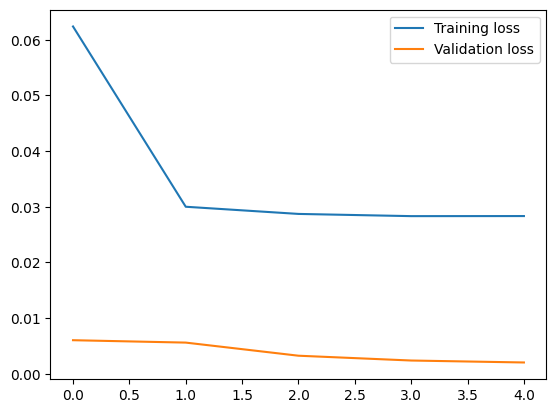

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [33]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [42]:
n_future=90
forecast_period_dates=pd.date_range(list(train_dates)[-1],periods=n_future,freq='1d').tolist()

In [50]:
forecast_period_dates

[Timestamp('2023-06-16 00:00:00', freq='D'),
 Timestamp('2023-06-17 00:00:00', freq='D'),
 Timestamp('2023-06-18 00:00:00', freq='D'),
 Timestamp('2023-06-19 00:00:00', freq='D'),
 Timestamp('2023-06-20 00:00:00', freq='D'),
 Timestamp('2023-06-21 00:00:00', freq='D'),
 Timestamp('2023-06-22 00:00:00', freq='D'),
 Timestamp('2023-06-23 00:00:00', freq='D'),
 Timestamp('2023-06-24 00:00:00', freq='D'),
 Timestamp('2023-06-25 00:00:00', freq='D'),
 Timestamp('2023-06-26 00:00:00', freq='D'),
 Timestamp('2023-06-27 00:00:00', freq='D'),
 Timestamp('2023-06-28 00:00:00', freq='D'),
 Timestamp('2023-06-29 00:00:00', freq='D'),
 Timestamp('2023-06-30 00:00:00', freq='D'),
 Timestamp('2023-07-01 00:00:00', freq='D'),
 Timestamp('2023-07-02 00:00:00', freq='D'),
 Timestamp('2023-07-03 00:00:00', freq='D'),
 Timestamp('2023-07-04 00:00:00', freq='D'),
 Timestamp('2023-07-05 00:00:00', freq='D'),
 Timestamp('2023-07-06 00:00:00', freq='D'),
 Timestamp('2023-07-07 00:00:00', freq='D'),
 Timestamp

In [43]:
forecast = model.predict(trainX[-n_future:])

3/3 [==============================] - 0s 18ms/step


In [44]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [51]:
y_pred_future

array([ 82.745224,  82.83523 ,  82.778755,  82.6362  ,  82.60294 ,
        82.732216,  83.033485,  83.37655 ,  83.62447 ,  83.72336 ,
        83.832855,  83.92288 ,  83.98421 ,  84.10992 ,  84.31198 ,
        84.51986 ,  84.79103 ,  85.18927 ,  85.72198 ,  86.23905 ,
        86.72446 ,  87.59949 ,  88.62431 ,  89.36437 ,  90.10164 ,
        90.47751 ,  90.826225,  91.0798  ,  91.20276 ,  91.42919 ,
        91.54537 ,  91.69416 ,  91.82077 ,  92.13022 ,  92.53444 ,
        93.046074,  93.5503  ,  94.10646 ,  94.78006 ,  95.373245,
        95.684845,  95.71322 ,  95.64114 ,  95.50366 ,  95.365036,
        95.212776,  95.17219 ,  95.36554 ,  95.84979 ,  96.56474 ,
        97.42482 ,  98.26136 ,  99.023605,  99.53333 ,  99.49071 ,
        99.25855 ,  99.04141 ,  99.12343 ,  99.425026,  99.93758 ,
       100.250404, 100.52789 , 100.728455, 100.9103  , 100.91913 ,
       100.74389 , 100.43185 , 100.35524 , 100.4839  , 100.851326,
       101.38158 , 102.067444, 102.800224, 103.17057 , 103.034

In [45]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [52]:
forecast_dates

[datetime.date(2023, 6, 16),
 datetime.date(2023, 6, 17),
 datetime.date(2023, 6, 18),
 datetime.date(2023, 6, 19),
 datetime.date(2023, 6, 20),
 datetime.date(2023, 6, 21),
 datetime.date(2023, 6, 22),
 datetime.date(2023, 6, 23),
 datetime.date(2023, 6, 24),
 datetime.date(2023, 6, 25),
 datetime.date(2023, 6, 26),
 datetime.date(2023, 6, 27),
 datetime.date(2023, 6, 28),
 datetime.date(2023, 6, 29),
 datetime.date(2023, 6, 30),
 datetime.date(2023, 7, 1),
 datetime.date(2023, 7, 2),
 datetime.date(2023, 7, 3),
 datetime.date(2023, 7, 4),
 datetime.date(2023, 7, 5),
 datetime.date(2023, 7, 6),
 datetime.date(2023, 7, 7),
 datetime.date(2023, 7, 8),
 datetime.date(2023, 7, 9),
 datetime.date(2023, 7, 10),
 datetime.date(2023, 7, 11),
 datetime.date(2023, 7, 12),
 datetime.date(2023, 7, 13),
 datetime.date(2023, 7, 14),
 datetime.date(2023, 7, 15),
 datetime.date(2023, 7, 16),
 datetime.date(2023, 7, 17),
 datetime.date(2023, 7, 18),
 datetime.date(2023, 7, 19),
 datetime.date(2023, 7,

In [46]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [53]:
df_forecast

,Date,Open
0,2023-06-16,82.745224
1,2023-06-17,82.835228
2,2023-06-18,82.778755
3,2023-06-19,82.636200
4,2023-06-20,82.602943
...,...,...
85,2023-09-09,105.238594
86,2023-09-10,105.501053
87,2023-09-11,105.709831
88,2023-09-12,105.701195


In [48]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

<ipython-input-48-023fd395994a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [54]:
original

,Date,Open
14683,2020-05-01,41.654957
14684,2020-05-04,39.344261
14685,2020-05-05,39.219360
14686,2020-05-06,38.719749
14687,2020-05-07,37.845432
...,...,...
15466,2023-06-12,106.309998
15467,2023-06-13,106.029999
15468,2023-06-14,106.720001
15469,2023-06-15,104.440002


In [57]:
combined_df = pd.concat([original, df_forecast], axis=0)

In [58]:
combined_df

,Date,Open
14683,2020-05-01,41.654957
14684,2020-05-04,39.344261
14685,2020-05-05,39.219360
14686,2020-05-06,38.719749
14687,2020-05-07,37.845432
...,...,...
85,2023-09-09,105.238594
86,2023-09-10,105.501053
87,2023-09-11,105.709831
88,2023-09-12,105.701195


<Axes: xlabel='Date', ylabel='Open'>

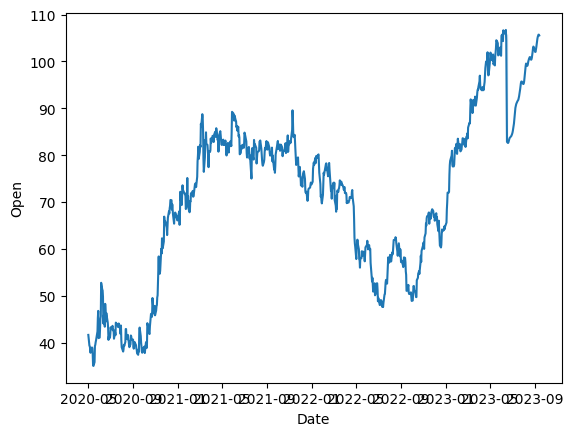

In [59]:
sns.lineplot(x=combined_df.Date, y=combined_df.Open)
# sns.lineplot(x=df_forecast.Date, y=df_forecast.Open)